In [1]:
# %pip install -e "/home/callum/projects/evo-ued[examples]"
# then restart the kernel

In [2]:
from jaxued import (
    load_runname_group_map_from_file,
    collect_histories_from_run_mapping,
    aggregate_mean_std, smooth_ewm, plot_mean_std,
    aggregate_quantiles, plot_median_quantiles,
    make_algorithm_palette,  # add this
)

ENTITY = "callumrlawson-pibbss"
PROJECT = "JAXUED_TEST"
STEP = "num_updates"
METRIC_RETURN = "return/mean"  # or e.g. "return/StandardMaze3"
METRIC_SOLVE = "solve_rate/mean"
CFG_PATH = "/home/callum/projects/evo-ued/config/combine_results_30k.json"
SAMPLES = 100_000 # no thinning of samples

# 1) Grouping defined by repo config (run_name -> algo)
runmap = load_runname_group_map_from_file(CFG_PATH)

# 2) Collect histories using mapping (no W&B group reliance)
df_return = collect_histories_from_run_mapping(
    ENTITY, PROJECT, runmap,
    step_key=STEP, metric_key=METRIC_RETURN,
    samples=SAMPLES,   # set None for full history
)

df_solve = collect_histories_from_run_mapping(
    ENTITY, PROJECT, runmap,
    step_key=STEP, metric_key=METRIC_SOLVE,
    samples=SAMPLES,   # set None for full history
)

ALG_PALETTE = make_algorithm_palette(sorted(df_return["group"].unique().tolist()))

# Quick sanity check
print(df_return.groupby("group")["run_id"].nunique().sort_values())

/home/callum/projects/evo-ued/src/jaxued/training_analysis.py:237: UserWarning: Duplicate runs for 'dr_softmin_eval250_seed9_30000a'. Using 5z2kz0cr (score=30000.0). Others: lwdyong6:21750.0, 5494bqdu:2000.0, g8ga87vx:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/src/jaxued/training_analysis.py:237: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed9_30000a'. Using z2kg4331 (score=30000.0). Others: 4wxgkyo7:2000.0, tddvc36j:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/src/jaxued/training_analysis.py:237: UserWarning: Duplicate runs for 'dr_baseline_eval250_seed3_30000a'. Using kv90hilu (score=30000.0). Others: 7ufgpt9e:22500.0
  warnings.warn(
/home/callum/projects/evo-ued/src/jaxued/training_analysis.py:237: UserWarning: Duplicate runs for 'dr_softmin_eval250_seed9_30000a'. Using 5z2kz0cr (score=30000.0). Others: lwdyong6:21750.0, 5494bqdu:2000.0, g8ga87vx:2000.0
  warnings.warn(
/home/callum/projects/evo-ued/src/jaxued/training_analysis.py:237: UserWarning: Du

group
ACCEL                 10
DR (baseline)         10
DR (evolutionary)     10
PLR (evolutionary)    10
Name: run_id, dtype: int64


In [3]:
from jaxued import WandbDataClient
import pandas as pd

client = WandbDataClient(ENTITY, PROJECT)

STEP = STEP  # e.g., "num_updates"
METRIC = METRIC_RETURN  # e.g., "return/mean"
step_candidates = [STEP, "num_updates", "Step", "_step", "global_step", "num_env_steps"]

rows = []
missing = []

for rid in df_return["run_id"].unique().tolist():
    r = client.get_run(rid)
    name = r.config.get("run_name") if "run_name" in dict(r.config) else r.name
    g = df_return.loc[df_return.run_id == rid, "group"].iloc[0]

    # Pull full history to avoid key filtering
    d_ds   = client.fetch_run_data(rid, keys=None, samples=2000)
    d_full = client.fetch_run_data(rid, keys=None, samples=None)

    def extract(df0):
        cols = df0.columns
        step_col = next((c for c in step_candidates if c in cols), None)
        if step_col is None or METRIC not in cols:
            return None, cols, step_col
        df = df0[[step_col, METRIC]].dropna().rename(columns={step_col: STEP})
        return df, cols, step_col

    ds,   ds_cols,   ds_step   = extract(d_ds.history_df)
    full, full_cols, full_step = extract(d_full.history_df)

    if full is None:
        missing.append({
            "group": g, "run_name": name, "run_id": rid,
            "reason": f"missing step/metric (step in {list(full_cols)[:10]}; metric present={METRIC in full_cols})"
        })
        continue

    rows.append({
        "group": g, "run_name": name, "run_id": rid,
        "rows_ds": 0 if ds is None else len(ds),
        "rows_full": len(full),
        "max_step_ds": None if ds is None else ds[STEP].max(),
        "max_step_full": full[STEP].max(),
        "step_col_full": full_step,
    })

counts = pd.DataFrame(rows).sort_values(["group", "run_name"])
print("Totals by group (rows):")
print(counts.groupby("group")[["rows_ds","rows_full"]].sum())
print("\nMissing/unsupported runs:")
pd.DataFrame(missing)

Totals by group (rows):
                    rows_ds  rows_full
group                                 
ACCEL                  1200       1200
DR (baseline)          1200       1200
DR (evolutionary)      1200       1200
PLR (evolutionary)     1200       1200

Missing/unsupported runs:


""


In [4]:
# from jaxued import WandbDataClient, load_runname_group_map_from_file

# # expected (from config)
# runmap = load_runname_group_map_from_file(CFG_PATH)
# expected_by_group = {}
# for rn, g in runmap.items():
#     expected_by_group.setdefault(g, set()).add(rn)

# # found (from the DataFrame used to plot)
# ids_by_group = {g: set(map(str, ids)) for g, ids in df_return.groupby("group")["run_id"].unique().items()}

# # resolve run_id -> human name (prefer config.run_name, else run.name)
# client = WandbDataClient(ENTITY, PROJECT)
# id_to_name = {}
# for rid in set().union(*ids_by_group.values()):
#     r = client.get_run(rid)
#     name = r.config.get("run_name") if "run_name" in dict(r.config) else r.name
#     id_to_name[rid] = name

# found_by_group = {g: {id_to_name[rid] for rid in ids} for g, ids in ids_by_group.items()}

# # print per-group lists
# for g in sorted(expected_by_group.keys() | found_by_group.keys()):
#     exp = sorted(expected_by_group.get(g, set()))
#     got = sorted(found_by_group.get(g, set()))
#     missing = sorted(set(exp) - set(got))
#     extra = sorted(set(got) - set(exp))
#     print(f"\nGroup: {g}")
#     print("Expected:", exp)
#     print("Found   :", got)
#     if missing:
#         print("Missing :", missing)
#     if extra:
#         print("Extra   :", extra)

In [5]:
# 3a) Smoothed mean ± std (aggregate, then smooth)
agg = aggregate_mean_std(df_return, STEP)
agg_smooth = smooth_ewm(agg, value_col="mean", span=20)
agg_q = aggregate_quantiles(df_return, STEP, q_low=0.25, q_high=0.75)

<Axes: xlabel='update', ylabel='return'>

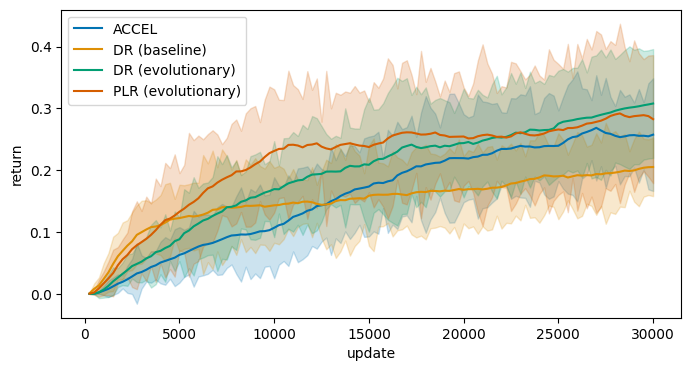

In [6]:
plot_mean_std(agg_smooth, step_key=STEP, palette_map=ALG_PALETTE, y_label="return")

<Axes: xlabel='update', ylabel='return'>

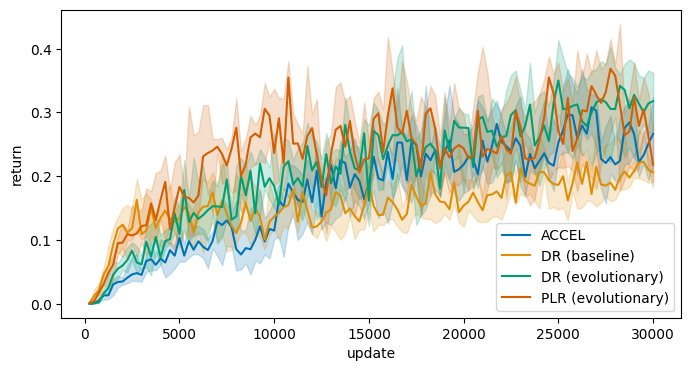

In [7]:
# 3b) Raw median + IQR (no smoothing/resampling)
plot_median_quantiles(agg_q, step_key=STEP, palette_map=ALG_PALETTE, y_label="return")

In [8]:
# 3a) Smoothed mean ± std (aggregate, then smooth)
agg = aggregate_mean_std(df_solve, STEP)
agg_smooth = smooth_ewm(agg, value_col="mean", span=20)
agg_q = aggregate_quantiles(df_solve, STEP, q_low=0.25, q_high=0.75)

<Axes: xlabel='update', ylabel='solve rate'>

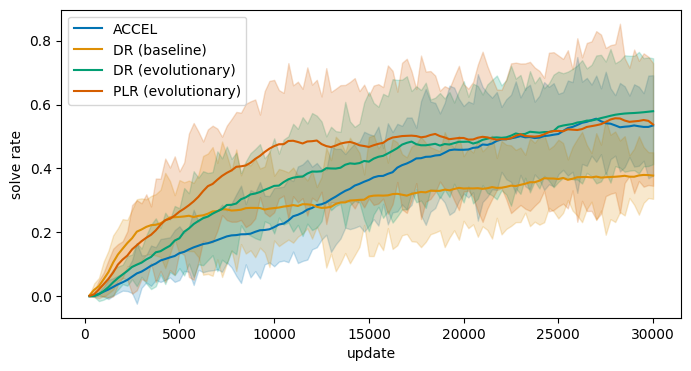

In [9]:
plot_mean_std(agg_smooth, step_key=STEP, palette_map=ALG_PALETTE, y_label="solve rate")

<Axes: xlabel='update', ylabel='solve rate'>

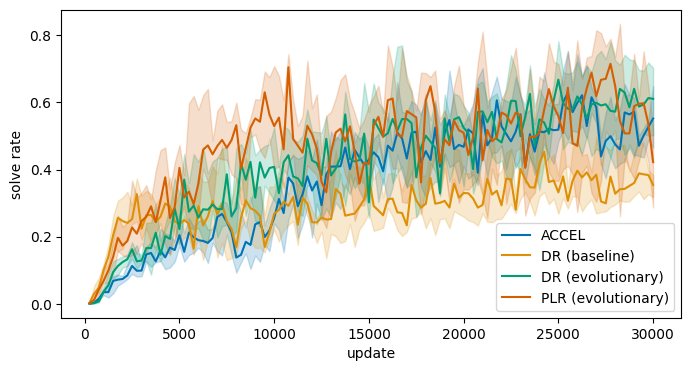

In [10]:
# 3b) Raw median + IQR (no smoothing/resampling)
plot_median_quantiles(agg_q, step_key=STEP, palette_map=ALG_PALETTE, y_label="solve rate")